## Setup
Always run these cells!

In [0]:
#@title Imports

!pip install pulp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pulp import *
import seaborn as sns
sns.set()

from google.colab import drive
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [0]:
def cross(A, B, f=lambda a,b: a+b):
  """Returns a matrix of all combination of items in A and B conbined by f"""
  return np.array([[f(a,b) for b in B] for a in A])

PATH = '/content/gdrive/My Drive/IE2110_Group_10_Project/data team'
BIG_M = 10e5

Layover costs loaded into matrix "layover"


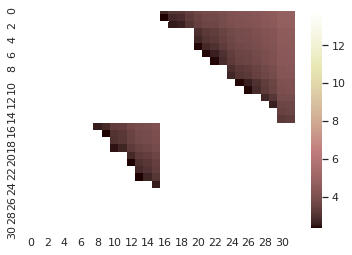

data loaded into dataframe "flights"


,flight,from,to,departure,arrival,duration_hours,min_crew,max_crew
0,1,SG,Melbourne,2019-11-02 10:00:00,2019-11-02 18:00:00,8,6,12
1,2,SG,Melbourne,2019-11-02 16:10:00,2019-11-03 00:10:00,8,6,12
2,3,SG,Melbourne,2019-11-02 20:05:00,2019-11-03 04:05:00,8,6,12
3,4,SG,Melbourne,2019-11-03 07:45:00,2019-11-03 15:45:00,8,6,12
4,5,SG,Melbourne,2019-11-03 11:00:00,2019-11-03 19:00:00,8,6,12


In [0]:
#@title load data



# Layover cost matrix
layover = np.genfromtxt(f'{PATH}/layover.csv', delimiter=',')

# Flight data
flights = pd.read_csv(f'{PATH}/flights.csv')
time_cols = ['departure', 'arrival']
num_cols = ['duration_hours', 'min_crew', 'max_crew']

flights[time_cols] = flights[time_cols].apply(pd.to_datetime)
flights[num_cols] = flights[num_cols].apply(pd.to_numeric)
flights.index = range(32)

# Check data
print('Layover costs loaded into matrix "layover"')
sns.heatmap(np.log(layover), cmap='pink')
plt.show()

print('data loaded into dataframe "flights"')
flights.head()

## Prepare data
We only need to run this when we upload new data.

In [0]:
# !pip install --upgrade -q gspread

# from google.colab import auth
# auth.authenticate_user()

# import gspread
# from oauth2client.client import GoogleCredentials

# # Load data from google sheets
# gc = gspread.authorize(GoogleCredentials.get_application_default())
# wb = gc.open('Project Model Data')
# ws = workbook.worksheet('tidy_data')

# # get_all_values gives a list of rows.
# rows = ws.get_all_values()

# # Convert to a DataFrame and render.
# flights_raw = pd.DataFrame.from_records(rows)

# # Clean data
# flights = flights_raw.copy()
# flights.columns = flights.iloc[0, :]
# flights.drop(index=0, inplace=True)

# time_cols = ['departure_time', 'arrival_time']
# flights[time_cols] = flights[time_cols].apply(pd.to_datetime)

# num_cols = ['flight', 'departure_day', 'arrival_day', 'duration_hours', 'min_crew', 'max_crew']
# flights[num_cols] = flights[num_cols].apply(pd.to_numeric)

# # Combine time and day
# flights['departure'] = flights.departure_time + flights.departure_day.apply(lambda x: timedelta(days=x))
# flights['arrival'] = flights.arrival_time + flights.arrival_day.apply(lambda x: timedelta(days=x))

# cols = ['flight', 'from', 'to', 'departure', 'arrival', 'duration_hours', 'min_crew', 'max_crew']
# flights = flights[cols]

# # Check data
# print('data loaded into dataframe "flights"')
# flights.head()

In [0]:
# def layover_cost(first, second, MIN_LAYOVER=10, BIG_M=10e9):
#   """Returns layover cost in hours if valid else big M"""
#   layover = (second - first).total_seconds() / 60 / 60
#   return BIG_M if layover<MIN_LAYOVER else layover

# # cost is a matrix of layover cost for each pair and mask is a boolean matrix indicating a valid pairing
# cost = cross(flights.arrival, flights.departure, lambda a,b: layover_cost(a, b, BIG_M=BIG_M)) 
# mask = cross(flights['from'], flights.to, lambda a,b: a==b)
# layover = (mask*cost) + (~mask*BIG_M)

# plt.figure(figsize=(10,7))
# ax = sns.heatmap(np.log(layover), xticklabels = flights.index, yticklabels = flights.index, cmap='pink')
# ax.set_title('log(layover cost) of connecting flight pairs')
# ax.set_ylabel('Arrivals')
# ax.set_xlabel('Departures')
# plt.show()

In [0]:
# flights.to_csv(f'{PATH}/flights.csv', index=False)
# np.savetxt(f'{PATH}/layover.csv', layover, delimiter=',')

# Pairing problem

This model simultaneously solves for connecting flights at Singapore and Melbourne and is parametrized by `k`.

The parameter `k` can be interpreted as the number of flight pairs we want to obtain for each flight. This is helpful as it allows us to limit the max number of decision variables passed on to the assignment problem, giving us some control over the problem space. 

Another advantage of this method is that the output can be interpreted directly as the edge list of a graph from which all possible flight paths can be generated.

In [0]:
F = flights.index.values
k = 2

pairing = LpProblem("pairing", LpMinimize)
pair = LpVariable.dicts("pair", (F, F), 0, 1, LpInteger)

# Objective
pairing += lpSum([layover[i, j] * pair[i][j] for i in F for j in F]), "objective"

# Constraints
for i in F:
  pairing += lpSum([pair[i][j] for j in F]) >= k, "" # outgoing flights should be assigned at least k times

for j in F:
  pairing += lpSum([pair[i][j] for i in F]) >= k, "" # incoming flights should be assigned at least k times

# Solve!
print('Success!' if pairing.solve() == 1 else 'Oof something went wrong ; ;')

Success!


Here we visualize the assignments and store them in `pairing`. White cells correspond to a layover cost of M and should be disregarded.

It is key to note that `pairing` is equivalent to an edge list of the graph representing our possible flight legs where: 

- Vertices represents a flight
- An edge between two vertices represents the feasibility of the two corresponding flights pairing
- Each edge weight represents the associated layover cost of that pairing

Notably, conducting a DFS on this graph is equivalent to finding all possible chains of feasible flight pairings. This is convenient as flight chains form one dimension of our decision variables in the assignment problem.

Additionally, we can see that solving the pairing problem with a small `k` (k << n) allows us to find a good set of flight chains in linear time using a DFS. This is a significant improvement over iterating over all possible chains, where many poor chains will be discarded.
```
Time complexity of DFS = O[V+E] = O[n + n*k] = O[n]
```

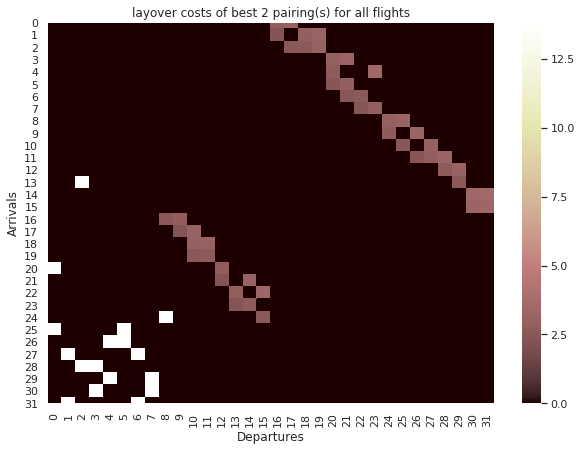

(0, 16) -> 16.583333333333332
(0, 17) -> 22.666666666666668
(1, 16) -> 10.416666666666666
(1, 18) -> 17.75
(1, 19) -> 25.416666666666668
(2, 17) -> 12.583333333333334
(2, 18) -> 13.833333333333334
(2, 19) -> 21.5
(3, 20) -> 18.833333333333332
(3, 21) -> 24.916666666666668
(4, 20) -> 15.583333333333334
(4, 23) -> 30.583333333333332
(5, 20) -> 10.833333333333334
(5, 21) -> 16.916666666666668
(6, 21) -> 10.833333333333334
(6, 22) -> 13.583333333333334
(7, 22) -> 11.0
(7, 23) -> 17.166666666666668
(8, 24) -> 18.833333333333332
(8, 25) -> 24.916666666666668
(9, 24) -> 15.583333333333334
(9, 26) -> 24.416666666666668
(10, 25) -> 10.833333333333334
(10, 27) -> 19.75
(11, 26) -> 11.0
(11, 27) -> 17.166666666666668
(11, 28) -> 26.166666666666668
(12, 28) -> 15.583333333333334
(12, 29) -> 22.916666666666668
(13, 2) -> 1000000.0
(13, 29) -> 13.833333333333334
(14, 30) -> 32.25
(14, 31) -> 35.0
(15, 30) -> 24.916666666666668
(15, 31) -> 27.666666666666668
(16, 8) -> 13.166666666666666
(16, 9) -> 1

In [0]:
#@title Inspect optimal pairs

plt.figure(figsize=(10, 7))
ax = sns.heatmap(np.log(layover) * cross(F, F, lambda a,b: value(pair[a][b]) != 0), cmap='pink')
ax.set_title(f'layover costs of best {k} pairing(s) for all flights')
ax.set_ylabel('Arrivals')
ax.set_xlabel('Departures')
plt.show()

edge_list = {(i, j): layover[i, j] for i in F for j in F if value(pair[i][j]) != 0}
for key, val in edge_list.items():
  print(f'{key} -> {val}')

obj = pairing.objective.value()
n_infeasible = obj // BIG_M
obj_feasible = obj % BIG_M
print(f'total layover time (hours) = {obj_feasible} ({len(edge_list) - int(n_infeasible)}/{len(edge_list)} feasible pairings)')

# Data processing between models

Process the pairing problem solution to generate a set of feasible schedules that meet the minimum layover requirements. 

Note that this allows for schedules that start and end at any location! If we want SG to act as a crew base, we have to filter the results further (but this is relatively trivial!)

In [0]:
def search_memo(f):
  """Tailored memoization for seach function"""
  cache = dict()
  def wrapper(adj_list, u=None, d=0):
    if (u, d) not in cache:
      cache[(u, d)] = tuple(f(adj_list, u, d))
    return cache[(u, d)]
  return wrapper

@search_memo
def search(adj_list, u=None, d=0):
  """
  Performs a DFS on a graph for all (path, distance) pairs.
  Optional params:
  - u : Starting vertice. If u is not supplied, DFS searches for all possible u.
  - d : Starting distance (Default: 0)
  """

  if u is None:
    for v in adj_list:
      for result in search(adj_list, v, d):
        yield result

  elif u in adj_list:
    for v in adj_list[u]:
      for path, path_dist in search(adj_list, v, d + adj_list[u][v]):
        yield ((u, *path), path_dist)

  elif u not in adj_list:
    yield ((u,), d)

In [0]:
# Filter out infeasible pairings
feasible = {key:val for key,val in edge_list.items() if val != BIG_M}

# Convert to adjacency list
from collections import defaultdict

L = defaultdict(dict)
for a, b in feasible:
  L[a][b] = feasible[(a, b)]
L = dict(L)

# DFS for flight routes and distances
paths = dict(search(L))
paths

{(0, 16, 8, 24, 15, 30): 86.66666666666666,
 (0, 16, 8, 24, 15, 31): 89.41666666666666,
 (0, 16, 8, 25): 54.66666666666667,
 (0, 16, 9, 24, 15, 30): 86.66666666666667,
 (0, 16, 9, 24, 15, 31): 89.41666666666667,
 (0, 16, 9, 26): 57.41666666666667,
 (0, 17, 9, 24, 15, 30): 86.66666666666667,
 (0, 17, 9, 24, 15, 31): 89.41666666666667,
 (0, 17, 9, 26): 57.41666666666667,
 (0, 17, 10, 25): 54.66666666666667,
 (0, 17, 10, 27): 63.583333333333336,
 (1, 16, 8, 24, 15, 30): 80.5,
 (1, 16, 8, 24, 15, 31): 83.25,
 (1, 16, 8, 25): 48.5,
 (1, 16, 9, 24, 15, 30): 80.5,
 (1, 16, 9, 24, 15, 31): 83.25,
 (1, 16, 9, 26): 51.25,
 (1, 18, 10, 25): 48.50000000000001,
 (1, 18, 10, 27): 57.41666666666667,
 (1, 18, 11, 26): 51.25,
 (1, 18, 11, 27): 57.41666666666667,
 (1, 18, 11, 28): 66.41666666666667,
 (1, 19, 10, 25): 48.50000000000001,
 (1, 19, 10, 27): 57.41666666666667,
 (1, 19, 11, 26): 51.25,
 (1, 19, 11, 27): 57.41666666666667,
 (1, 19, 11, 28): 66.41666666666667,
 (2, 17, 9, 24, 15, 30): 76.583333

# Assignment problem

In [0]:
min_crew = 3
max_crew = 16
num_crew = len(F) * max_crew # Maximal crew demand

# Initialize variables and parameters
crew_cost = pd.read_csv(f'/content/gdrive/My Drive/IE2110_Group_10_Project/data team/Crew_data.csv')
crew_cost = crew_cost['Addon pay (per hour)']
crew_cost = crew_cost.sample(num_crew, replace=True)
time_cost = paths.values()

# get cost for each assignment 
# = crew_pay + layover_cost
# = (hourly_add_on_pay_in_dollars * 16 hours) + ($100 * layover_time_in_hours)
K = cross(crew_cost, time_cost, lambda a,b: a*16 + 100*b)

# Crew members
C = list(range(num_crew))

# Flight schedules
P = dict(enumerate(paths))

# Groups of schedules by the flights they contain
group = [list() for f in F]
for i, schedule in P.items():
  for flight in schedule:
    group[flight].append(i)

# Initialize LP
assignment = LpProblem("assignment", LpMinimize)
match = LpVariable.dicts("match", (C, P), 0, 1, LpInteger)

# Objective
assignment += lpSum([K[c][p] * match[c][p] for c in C for p in P]), "objective" # min cost of assigning schedules to crew members

# Constraints
for i, c in enumerate(C):
  assignment += lpSum([match[c][p] for p in P]) <= 1, f"assignment_{i}" # each crew is assigned to one schedule

for i, G in enumerate(group):
  if G == []: continue # skip if flight is infeasible from pairing problem
  assignment += lpSum([match[c][p] for c in C for p in G]) <= max_crew, f"max_crew_{i}" # no more than max_crew per flight
  assignment += lpSum([match[c][p] for c in C for p in G]) >= min_crew, f"min_crew_{i}" # no less than min_crew per flight

# Solve!
print('Success' if assignment.solve() == 1 else 'Oof something went wrong ; ;')

Success


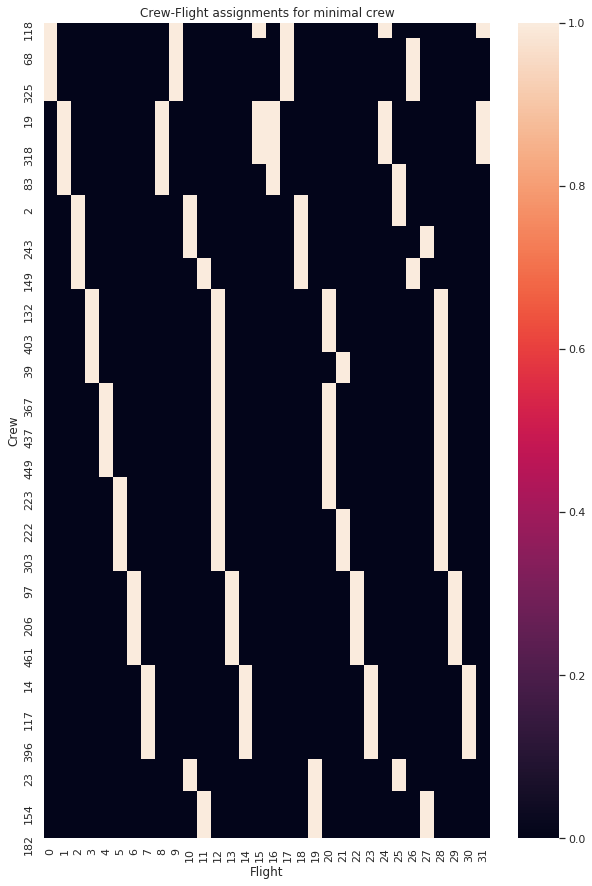

In [0]:
matches = [(c, p) for c in C for p in P if value(match[c][p]) != 0]
matches.sort(key=lambda x: x[1])

table = pd.DataFrame(columns=F, index=pd.unique([c for c,p in matches]))
for c, p in matches:
  for flight in P[p]:
    table.loc[c, flight] = 1

plt.figure(figsize=(10, 15))
ax = sns.heatmap(table.fillna(0))
ax.set_title('Crew-Flight assignments for minimal crew')
ax.set_ylabel('Crew')
ax.set_xlabel('Flight')
plt.show()

In [0]:
routes = pd.DataFrame(matches)
routes.columns = ['crew', 'route']
counts = routes.groupby('route').count()
print(counts)

obj = assignment.objective.value()
print(f'total cost of scheduling all flights = {obj}')
print(f'total employees used = {counts.values.sum()}')

       crew
route      
7         1
8         2
12        2
13        1
32        1
33        1
34        1
42        2
44        1
48        3
53        1
55        2
63        3
70        3
106       1
109       2
total cost of scheduling all flights = 153042.0
total employees used = 27


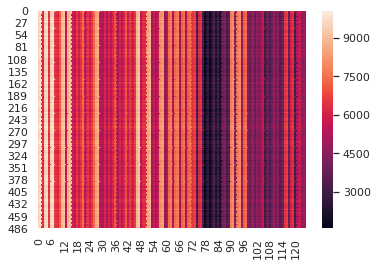

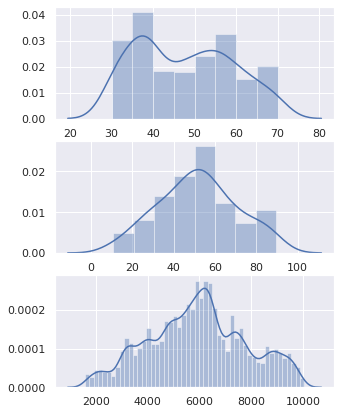

mean: 5938.614583333333
sd: 1891.5937221790855


In [0]:
sns.heatmap(K)
plt.show()

plt.figure(figsize=(5,7))

plt.subplot(3,1,1)
sns.distplot(crew_cost)

plt.subplot(3,1,2)
sns.distplot(list(time_cost))

plt.subplot(3,1,3)
sns.distplot(K.flatten())

plt.show()

print('mean:', K.mean())
print('sd:', K.std())

In [0]:
for name, c in assignment.constraints.items():
  print(name, c.slack)

assignment_0 1.0
assignment_1 1.0
assignment_2 -0.0
assignment_3 1.0
assignment_4 1.0
assignment_5 1.0
assignment_6 1.0
assignment_7 1.0
assignment_8 1.0
assignment_9 1.0
assignment_10 1.0
assignment_11 1.0
assignment_12 1.0
assignment_13 1.0
assignment_14 -0.0
assignment_15 1.0
assignment_16 1.0
assignment_17 1.0
assignment_18 1.0
assignment_19 -0.0
assignment_20 1.0
assignment_21 1.0
assignment_22 1.0
assignment_23 -0.0
assignment_24 1.0
assignment_25 1.0
assignment_26 1.0
assignment_27 1.0
assignment_28 1.0
assignment_29 1.0
assignment_30 1.0
assignment_31 1.0
assignment_32 1.0
assignment_33 1.0
assignment_34 1.0
assignment_35 1.0
assignment_36 1.0
assignment_37 1.0
assignment_38 1.0
assignment_39 -0.0
assignment_40 1.0
assignment_41 1.0
assignment_42 1.0
assignment_43 1.0
assignment_44 1.0
assignment_45 1.0
assignment_46 1.0
assignment_47 1.0
assignment_48 1.0
assignment_49 1.0
assignment_50 1.0
assignment_51 1.0
assignment_52 1.0
assignment_53 1.0
assignment_54 1.0
assignment_55 1

In [0]:
assignment.coefficients.

Output hidden; open in https://colab.research.google.com to view.